In [1]:
import os
import pandas as pd
import seaborn as sns
import h5py as h5
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils.metrics import GTSortingComparison
from model.Lca import LCA1iter, NSS_online
from utils.build_dataset import init_dataloader
import spikeinterface.full as si
import pickle

# PCA+KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# WaveClus3
import waveclus.pywaveclus.spike_detection as sd
import waveclus.pywaveclus.waveform_extraction as we
import waveclus.pywaveclus.feature_extraction as fe
import waveclus.pywaveclus.clustering as clu
from spikeinterface.preprocessing import filter

batch_size = 16
fs = 10000
nchan = 4
nneurons = 5


def load_dataset(ds, tmax=180):
    data_file = ds
    with h5.File(data_file, "r") as f:
        wvs = np.array(f["wvs"][:], dtype=np.float32)
        gt_raster = np.array(f["gt_raster"][:], dtype=np.int32)
        peaks_idx = np.array(f["peaks_idx"][:], dtype=np.int32)
        try:
            snr = np.array(f["snr"][:], dtype=np.float32)
        except:
            snr = np.array(f["snr"], dtype=np.float32)
    f.close()
    # normalize waveforms with l2-norm
    l2_norm = np.linalg.norm(wvs, ord=2, axis=1)
    if np.sum(l2_norm < 1e-6) > 0:
        print("Warning: some waveforms are null")
    wvs = wvs / np.linalg.norm(wvs, ord=2, axis=1)[:, None]
    # filter and keep only wvs which peaks_idx are below tmax
    mask_detected = peaks_idx < tmax * fs
    mask_gt = gt_raster[0] < tmax * fs
    wvs, peaks_idx = wvs[mask_detected], peaks_idx[mask_detected]
    gt_raster = gt_raster[:, mask_gt]
    dataset = {"wvs": wvs, "gt_raster": gt_raster, "raster": peaks_idx, "snr": snr}
    dataloader = init_dataloader(wvs, peaks_idx, batch_size, normalize=False)
    return dataset, dataloader

### Run NSS

In [2]:
def run_nss_vary_n2(dataloader, seed, natoms2):
    params_nss = {
        "n_atoms1": 120,
        "n_atoms2": natoms2,
        "D1_positive": False,
        "D2_positive": True,
        "th1": 0.04,
        "th2": 0.04,
        "fs": fs,
        "tau": 2e-3,
        "iters": 200,
        "lr": 0.07,
        "n_model": "TDQ",
        "q": 2**2 - 1,
        "seed": seed,
    }

    params_nss["gamma"] = 1 / params_nss["fs"] / params_nss["tau"]

    ## init lca1
    lca1 = LCA1iter(
        input_size=next(iter(dataloader))[0].shape[1],
        gamma=params_nss["gamma"],
        threshold=params_nss["th1"],
        n_atoms=params_nss["n_atoms1"],
        lr=params_nss["lr"],
        neuron_model=params_nss["n_model"],
        q=params_nss["q"],
        D_positive=params_nss["D1_positive"],
        seed=params_nss["seed"],
    )
    lca2 = LCA1iter(
        input_size=params_nss["n_atoms1"],
        gamma=params_nss["gamma"],
        threshold=params_nss["th2"],
        n_atoms=params_nss["n_atoms2"],
        lr=params_nss["lr"],
        neuron_model=params_nss["n_model"],
        q=params_nss["q"],
        D_positive=params_nss["D2_positive"],
        seed=params_nss["seed"],
    )
    nss = NSS_online(lca1, lca2, params_nss["iters"], scale_factor=0.8)

    # training NSS
    nss_out = []
    n_spikes = []
    a1 = []
    for _, (bi, ri) in enumerate(tqdm(dataloader)):
        if int(ri[-1]) / fs > 120:
            nss.lca1.lr, nss.lca2.lr = 0.01, 0.01
            nss.iters = 64
            n_spikes.append(nss.lca1.n_spikes + nss.lca2.n_spikes)
        nss(bi)
        a1.append(nss.lca1.a.numpy())
        nss_out.append(nss.lca2.decoded_out.numpy())

    nss_out = np.concatenate(nss_out, axis=0)
    n_spikes = np.concatenate(n_spikes, axis=0)
    a1 = np.concatenate(a1, axis=0)
    labels = np.argmax(nss_out, axis=1).astype(int)
    # print(f"scale factor : {nss.scale_factor}")
    return labels, n_spikes, a1

In [3]:
# Hyperparameters
seed = 0
nneurons = 5
ds = 49  # [49, 62, 71, 209]
data = f"data/tetrode/tetrode{ds}_n5_static.h5"
# data = "data/hc1/hc1_d533101_dth5_tmax240_noburst.h5"
dataset, dataloader = load_dataset(data, tmax=180)
print(f"snr = {dataset['snr']}")

# fscore parameters
peaks = dataset["raster"]
gtr = dataset["gt_raster"]
spike_packet = 300

snr = [ 6.224137  15.374965   3.1914275  4.113743  10.44634  ]


# Plot NSS vs LCA+KMeans

### Get score with varying LCA2 size

In [4]:
# # Run NSS
# natoms2 = [3, 5, 10, 30, 50, 100]
# ntrials = 10
# seed = 0
# nss_score = np.zeros((len(natoms2), ntrials))
# for o, os in enumerate(natoms2):
#     print(f" ### Running NSS with n_atoms2 = {os} ###")
#     for t in tqdm(range(ntrials)):
#         seed = t
#         label_nss, nss_out, a1 = run_nss_vary_n2(dataloader, seed, natoms2=os)

#         # Compute fscore
#         fscore_nss_packet = []
#         for i in range(0, len(peaks), spike_packet):
#             if i + spike_packet >= len(peaks):
#                 break
#             mask_pred = (peaks >= peaks[i]) & (peaks < peaks[i + spike_packet])
#             mask_gtr = (gtr[0] >= peaks[i]) & (gtr[0] < peaks[i + spike_packet])
#             gtsort_comp = GTSortingComparison(
#                 label_nss[mask_pred],
#                 peaks[mask_pred],
#                 gtr[:, mask_gtr],
#                 fs,
#                 delta_time=1,
#             )
#             fscore_nss_packet.append(gtsort_comp.get_fscore().round(4))
#         fscore_nss_packet = np.array(fscore_nss_packet)
#         nss_score[o, t] = fscore_nss_packet[-10:].mean()
#         print(f"F1s NSS packet mean: {fscore_nss_packet[-10:].mean()*100:.2f}%")
# # save nss_score to npy
# np.save(f"logs/suppfigs/nss_score_tetrode{ds}_n5_static.npy", nss_score)

### Get f1-score with varying n_clusters of K-Means

In [5]:
# output_sizes = [3, 5, 10, 30, 50, 100]
# seed = 0
# ntrials = 10
# lcakmeans = np.zeros((len(output_sizes), ntrials))

# for o, n_clusters in enumerate(output_sizes):
#     print(f"### N clusters = {n_clusters} ###")
#     for t in tqdm(range(ntrials), desc="trials"):
#         seed += t
#         labels = np.zeros(len(peaks))
#         kmeans = KMeans(
#             n_clusters=n_clusters,
#             init="k-means++",
#             random_state=seed,
#             n_init="auto",
#         ).fit(a1[peaks < 70 * fs])
#         labels[peaks < 70 * fs] = kmeans.predict(a1[peaks < 70 * fs])
#         labels[~(peaks < 70 * fs)] = kmeans.predict(a1[~(peaks < 70 * fs)])
#         # compute fscore every packet of Ns spikes processed
#         spike_processed, fscore_pcakm = [], []
#         for i in range(0, len(peaks), spike_packet):
#             if i + spike_packet >= len(peaks):
#                 break
#             spike_processed.append(i + spike_packet)
#             mask_pred = (peaks >= peaks[i]) & (peaks < peaks[i + spike_packet])
#             mask_gtr = (gtr[0] >= peaks[i]) & (gtr[0] < peaks[i + spike_packet])
#             gtsort_pcakm = GTSortingComparison(
#                 labels[mask_pred],
#                 peaks[mask_pred],
#                 gtr[:, mask_gtr],
#                 fs,
#                 delta_time=1,
#                 # match_mode="hungarian",
#             )
#             fscore_pcakm.append(gtsort_pcakm.get_fscore().round(4))
#         fscore_pcakm = np.array(fscore_pcakm).T
#         spike_processed = np.array(spike_processed)
#         # print(f"F1s PCAKM packet: {fscore_pcakm.mean()*100:.2f}%")
#         lcakmeans[o, t] = fscore_pcakm[-10:].mean()
# # save lcakmeans to npy
# np.save(f"logs/suppfigs/lcakmeans_score_tetrode{ds}_n5_static.npy", lcakmeans)

### Plot stats for NSS and LCA+K-means on the same plot

In [6]:
# load nss_score and lcakmeans
nss_score = np.load(f"logs/suppfigs/nss_score_tetrode{ds}_n5_static.npy")
lcakmeans = np.load(f"logs/suppfigs/lcakmeans_score_tetrode{ds}_n5_static.npy")
ntrials = 10
output_sizes = [3, 5, 10, 30, 50, 100]

In [7]:
# compute mean, std and 95% CI
z = 1.96

# NSS
mean_nss = nss_score.mean(axis=1)
std_nss = nss_score.std(axis=1)
ci_nss = z * std_nss / np.sqrt(ntrials)


# LCA+K-Means
mean_lcakmeans = lcakmeans.mean(axis=1)
std_lcakmeans = lcakmeans.std(axis=1)

ci_lcakmeans = z * std_lcakmeans / np.sqrt(ntrials)

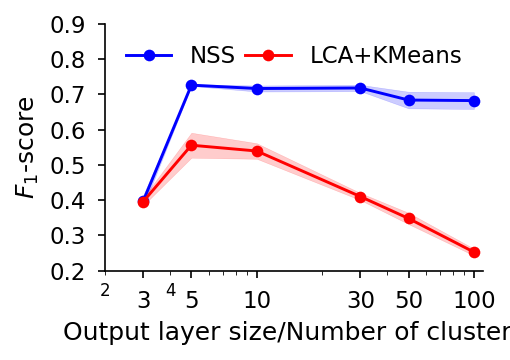

In [25]:
# plot lca-kmeans with fill_betwween 95% confidence interval
plt.style.use("seaborn-v0_8-paper")
fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=150)
ax.plot(output_sizes, mean_nss, marker="o", color="b", label="NSS")
ax.fill_between(
    output_sizes, mean_nss - ci_nss, mean_nss + ci_nss, color="b", alpha=0.2
)

ax.plot(output_sizes, mean_lcakmeans, marker="o", color="r", label="LCA+KMeans")
ax.fill_between(
    output_sizes,
    mean_lcakmeans - ci_lcakmeans,
    mean_lcakmeans + ci_lcakmeans,
    color="r",
    alpha=0.2,
)
# log10 x-scale
ax.set_xscale("log")
ax.set_xticks(output_sizes)
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(plt.ScalarFormatter())
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))
# for minor ticks only label those <10
ax.get_xaxis().set_minor_formatter(
    plt.FuncFormatter(lambda x, _: f"{int(x)}" if x < 6 else "")
)
ax.set_xticks(output_sizes)
ax.set_xticklabels(output_sizes, fontsize=11)
ax.set_yticks(np.arange(0.2, 1, 0.1))
ax.set_yticklabels([f"{i:.1f}" for i in np.arange(0.2, 1, 0.1)], fontsize=11)
ax.set_xlim(2, 110)
ax.set_ylim(0.2, 0.9)
ax.set_xlabel("Output layer size/Number of clusters", fontsize=12)
ax.set_ylabel("$F_{1}$-score", fontsize=12)
# remove top and right spines
ax.spines[["top", "right"]].set_visible(False)
# set custom legend only for the lines
lines, labels = ax.get_legend_handles_labels()
ax.legend(
    lines,
    ["NSS", "LCA+KMeans"],
    loc="upper center",
    fontsize=11,
    edgecolor="w",
    ncol=2,
    mode="expand",
)
plt.tight_layout()
plt.show()
# save figure
fig.savefig("figures/figsupp1_nss_lcakmeans_tetrode49_n5.svg", format="svg")

### Plot Sparsity

In [8]:
def run_nss_vary_N(dataloader, N):
    params_nss = {
        "n_atoms1": 120,
        "n_atoms2": 10,
        "D1_positive": False,
        "D2_positive": True,
        "th1": 0.04,
        "th2": 0.04,
        "fs": fs,
        "tau": 2e-3,
        "iters": 200,
        "lr": 0.07,
        "n_model": "TDQ",
        "q": 2**N - 1,
        "seed": 0,
    }

    params_nss["gamma"] = 1 / params_nss["fs"] / params_nss["tau"]

    ## init lca1
    lca1 = LCA1iter(
        input_size=next(iter(dataloader))[0].shape[1],
        gamma=params_nss["gamma"],
        threshold=params_nss["th1"],
        n_atoms=params_nss["n_atoms1"],
        lr=params_nss["lr"],
        neuron_model=params_nss["n_model"],
        q=params_nss["q"],
        D_positive=params_nss["D1_positive"],
        seed=params_nss["seed"],
    )
    lca2 = LCA1iter(
        input_size=params_nss["n_atoms1"],
        gamma=params_nss["gamma"],
        threshold=params_nss["th2"],
        n_atoms=params_nss["n_atoms2"],
        lr=params_nss["lr"],
        neuron_model=params_nss["n_model"],
        q=params_nss["q"],
        D_positive=params_nss["D2_positive"],
        seed=params_nss["seed"],
    )
    nss = NSS_online(lca1, lca2, params_nss["iters"], scale_factor=0.8)

    # training NSS
    nss_out = []
    n_spikes = []
    for _, (bi, ri) in enumerate(tqdm(dataloader)):
        if int(ri[-1]) / fs > 120:
            nss.lca1.lr, nss.lca2.lr = 0.01, 0.01
            nss.iters = 64
            n_spikes.append(nss.lca1.n_spikes + nss.lca2.n_spikes)
        nss(bi)
        nss_out.append(nss.lca2.decoded_out.numpy())

    nss_out = np.concatenate(nss_out, axis=0)
    n_spikes = np.concatenate(n_spikes, axis=0)
    return nss

In [9]:
# Hyperparameters
seed = 0
nneurons = 5
ds = 49  # [49, 62, 71, 209]
data = f"data/tetrode/tetrode{ds}_n5_static.h5"
# data = "data/hc1/hc1_d533101_dth5_tmax240_noburst.h5"
dataset, dataloader = load_dataset(data, tmax=240)
print(f"snr = {dataset['snr']}")

# fscore parameters
peaks = dataset["raster"]
gtr = dataset["gt_raster"]

snr = [ 6.224137  15.374965   3.1914275  4.113743  10.44634  ]


In [10]:
# Assign gt_label to detected spikes
# for each gtr spikes found a unique detected spike and assign the label, otherwise -1
gt_label = np.zeros(len(peaks))
peaks_idx_assigned = np.zeros(len(peaks), dtype=bool)
delta_t = 1e-3  # 0.5ms
for i, gti in enumerate(gtr[0]):
    mask = np.abs(peaks - gti) < delta_t * fs
    if np.sum(mask) == 1:
        if ~peaks_idx_assigned[mask]:
            gt_label[mask] = gtr[1][i]
            peaks_idx_assigned[mask] = True
        else:
            gt_label[mask] = -1
    elif np.sum(mask) > 1:
        idx = np.argmin(np.abs(peaks - gti))
        if ~peaks_idx_assigned[idx]:
            gt_label[idx] = gtr[1][i]
            peaks_idx_assigned[idx] = True
        else:
            gt_label[idx] = -1
    else:
        gt_label[idx] = -1

In [44]:
# N_values = [1, 2, 3, 4, 6, 8, 16, 32]
# sparsity = {N: {} for N in N_values}
# for i, N in enumerate(N_values):
#     nss = run_nss_vary_N(dataloader, N)
#     ts1, ts2 = [], []
#     for i in range(len(nss.lca1.ts)):
#         mean_ts1, mean_ts2 = nss.lca1.ts[i].copy(), nss.lca2.ts[i].copy()
#         # keep only values <1.
#         mean_ts1[mean_ts1 >= 1], mean_ts2[mean_ts2 >= 1] = 0, 0
#         ts1.append(np.sum(mean_ts1, axis=0) / np.sum(mean_ts1 > 0, axis=0))
#         ts2.append(np.sum(mean_ts2, axis=0) / np.sum(mean_ts2 > 0, axis=0))

#     ts1, ts2 = np.concatenate(ts1, axis=0) * 100, np.concatenate(ts2, axis=0) * 100

#     ss1, ss2 = (1 - np.concatenate(nss.lca1.ss, axis=0)) * 100, (
#         1 - np.concatenate(nss.lca2.ss, axis=0)
#     ) * 100

#     for ni in range(nneurons):
#         mask = gt_label == ni
#         sparsity[N][dataset["snr"][ni]] = {
#             "ss1": ss1[mask].mean().round(2),
#             "ss2": ss2[mask].mean().round(2),
#             "ts1": ts1[mask].mean().round(2),
#             "ts2": ts2[mask].mean().round(2),
#         }

# # save sparsity to pickle
# with open(f"logs/suppfigs/sparsity_tetrode{ds}_n5_static.pkl", "wb") as f:
#     pickle.dump(sparsity, f)
# f.close()

100%|██████████| 519/519 [00:30<00:00, 17.00it/s]


In [16]:
# load sparsity
N_values = [1, 2, 3, 4, 6, 8, 16, 32]
sparsity = {N: {} for N in N_values}
with open(f"logs/suppfigs/sparsity_tetrode{ds}_n5_static.pkl", "rb") as f:
    sparsity = pickle.load(f)
f.close()

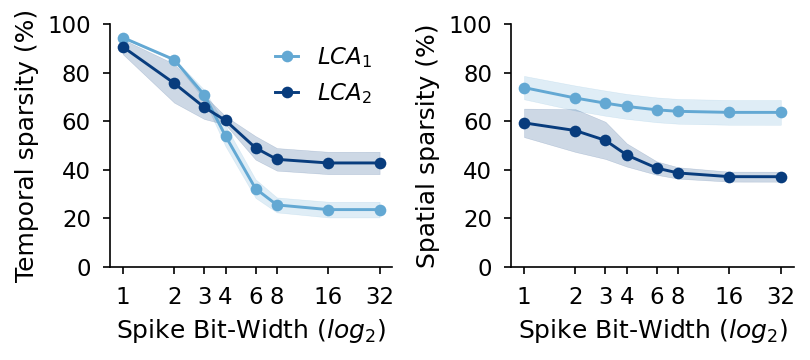

In [18]:
# compute mean and ci95% over SNR and plot temporal and spatial sparsity on a 2x1 subplot with fill_between
plt.style.use("seaborn-v0_8-paper")
c1, c2 = sns.color_palette("Blues", 20)[10], sns.color_palette("Blues", 20)[19]
fig, ax = plt.subplots(1, 2, figsize=(5.5, 2.5), dpi=150, sharex=True)
mean_ss1, mean_ss2 = np.zeros(len(N_values)), np.zeros(len(N_values))
mean_ts1, mean_ts2 = np.zeros(len(N_values)), np.zeros(len(N_values))
ci_ss1, ci_ss2 = np.zeros(len(N_values)), np.zeros(len(N_values))
ci_ts1, ci_ts2 = np.zeros(len(N_values)), np.zeros(len(N_values))
for i, N in enumerate(N_values):
    z = 1.96
    mean_ss1[i] = np.mean([sparsity[N][snr]["ss1"] for snr in sparsity[N].keys()])
    mean_ss2[i] = np.mean([sparsity[N][snr]["ss2"] for snr in sparsity[N].keys()])
    std_ss1 = np.std([sparsity[N][snr]["ss1"] for snr in sparsity[N].keys()])
    std_ss2 = np.std([sparsity[N][snr]["ss2"] for snr in sparsity[N].keys()])
    ci_ss1[i] = z * std_ss1 / np.sqrt(len(sparsity[N]))
    ci_ss2[i] = z * std_ss2 / np.sqrt(len(sparsity[N]))

    mean_ts1[i] = np.mean([sparsity[N][snr]["ts1"] for snr in sparsity[N].keys()])
    mean_ts2[i] = np.mean([sparsity[N][snr]["ts2"] for snr in sparsity[N].keys()])
    std_ts1 = np.std([sparsity[N][snr]["ts1"] for snr in sparsity[N].keys()])
    std_ts2 = np.std([sparsity[N][snr]["ts2"] for snr in sparsity[N].keys()])
    ci_ts1[i] = z * std_ts1 / np.sqrt(len(sparsity[N]))
    ci_ts2[i] = z * std_ts2 / np.sqrt(len(sparsity[N]))


ax[0].plot(N_values, mean_ts1, marker="o", color=c1, label="$LCA_{1}$")
ax[0].fill_between(N_values, mean_ts1 - ci_ts1, mean_ts1 + ci_ts1, alpha=0.2, color=c1)
ax[0].plot(N_values, mean_ts2, marker="o", color=c2, label="$LCA_{2}$")
ax[0].fill_between(N_values, mean_ts2 - ci_ts2, mean_ts2 + ci_ts2, alpha=0.2, color=c2)
ax[0].set_xlabel("Spike Bit-Width ($log_{2}$)", fontsize=12)
ax[0].set_ylabel("Temporal sparsity (%)", fontsize=12)
ax[0].set_xticks(N_values)
ax[0].set_xticklabels(N_values, fontsize=11)
ax[0].set_xscale("log", base=2)
ax[0].set_yticks(np.arange(0, 101, 20))
ax[0].set_yticklabels(np.arange(0, 101, 20), fontsize=11)
ax[0].legend(loc="best", fontsize=11, edgecolor="w", handlelength=1)
ax[0].spines[["top", "right"]].set_visible(False)

ax[1].plot(N_values, mean_ss1, marker="o", color=c1)
ax[1].fill_between(N_values, mean_ss1 - ci_ss1, mean_ss1 + ci_ss1, color=c1, alpha=0.2)
ax[1].plot(N_values, mean_ss2, marker="o", color=c2)
ax[1].fill_between(N_values, mean_ss2 - ci_ss2, mean_ss2 + ci_ss2, color=c2, alpha=0.2)
ax[1].set_ylabel("Spatial sparsity (%)", fontsize=12)
ax[1].set_xlabel("Spike Bit-Width ($log_{2}$)", fontsize=12)
ax[1].set_xticks(N_values)
ax[1].set_xticklabels(N_values, fontsize=11)
ax[1].set_yticks(np.arange(0, 101, 20))
ax[1].set_yticklabels(np.arange(0, 101, 20), fontsize=11)
ax[1].spines[["top", "right"]].set_visible(False)
plt.tight_layout()
plt.show()
# save figure
fig.savefig("figures/figsupp2_sparsity_tetrode49_n5_static.svg", format="svg")